In [1]:
import sys, os, time, shutil, random
from pathlib import Path
if '_cwd' not in locals():
    _cwd = os.getcwd()
    os.chdir(Path(_cwd)/'..')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

%load_ext autoreload
%autoreload 2

import numpy as np
np.set_printoptions(linewidth=120)
import pickle
from tabulate import tabulate
from tqdm.notebook import tqdm
import torch
from torch import nn, optim as opt
import torch.nn.functional as F
import torch.distributions as distrib
from torch.utils.data import Dataset, DataLoader, TensorDataset

%matplotlib notebook
import matplotlib.pyplot as plt

# from src.helix import helix_labels, helix_observations, ToyVAE
from src.shapes import ShapesVAE, Shapes3D

import omnifig as fig

from omnilearn import util

2022-05-26 11:27:51.661905: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /is/ei/fleeb/miniconda3/lib/python3.8/site-packages/cv2/../../lib64:/is/ei/fleeb/.mujoco/mujoco200/bin
2022-05-26 11:27:51.661956: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
device = 'cuda'

In [41]:
model = ShapesVAE()
model.load_state_dict(torch.load('model_a.pt'))
model.to(device)

ShapesVAE(
  (encoder): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
      (nonlin): ELU(alpha=1.0)
    )
    (1): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
      (nonlin): ELU(alpha=1.0)
    )
    (2): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
      (nonlin): ELU(alpha=1.0)
    )
    (3): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2

In [18]:
# from plethora import datasets

In [4]:
# dataset = datasets.Shapes3D(download=False, mode=None).prepare()
# len(dataset)

In [5]:
# class asdg:
#     pass
# self = asdg()

In [6]:

# self.factor_order = ['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape', 'orientation']
# self.factor_sizes = {'floor_hue': 10, 'wall_hue': 10, 'object_hue': 10,
#                      'scale': 8, 'shape': 4, 'orientation': 15}
# self._factor_steps = torch.as_tensor(np.array([self.factor_sizes[f] for f in self.factor_order] + [1])[::-1].cumprod()[-2::-1].copy())

In [7]:
# self._factor_steps

In [42]:
# data = Shapes3D(download=False, root=r'C:\Users\anwan\Documents\workspace\local_data\3dshapes')
data = Shapes3D(download=False)
len(data)

480000

In [43]:
data.images.shape

torch.Size([480000, 3, 64, 64])

In [44]:
seq = data.factor_traversal_images(5)#, base=data._factor_nums[0].long()-1)
seq.shape

torch.Size([15, 3, 64, 64])

<IPython.core.display.Javascript object>


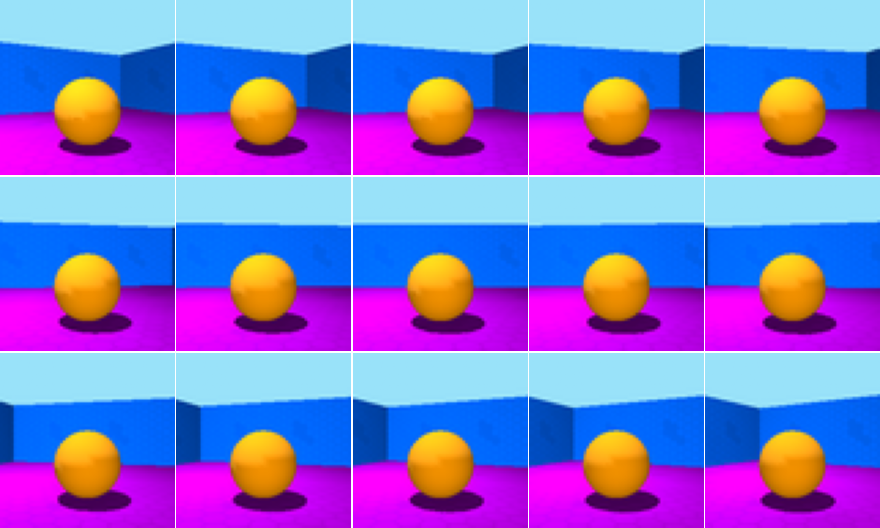

In [45]:
util.plot_imgs(seq);

In [46]:
X, _ = data[torch.randint(len(data), size=(60,))]
X.shape

torch.Size([60, 3, 64, 64])

<IPython.core.display.Javascript object>


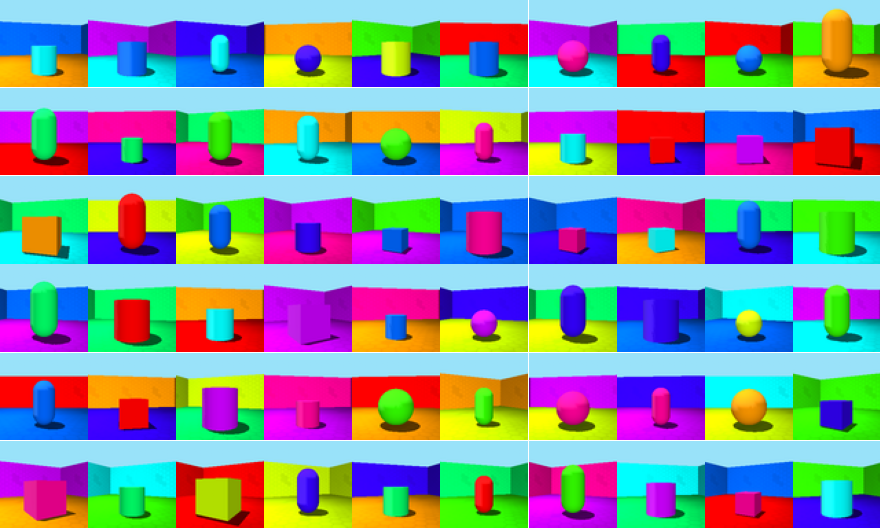

In [47]:
util.plot_imgs(X);

In [48]:
with torch.no_grad():
    R = model.reconstruct(X.cuda()).cpu()
R.shape

torch.Size([60, 3, 64, 64])

<IPython.core.display.Javascript object>


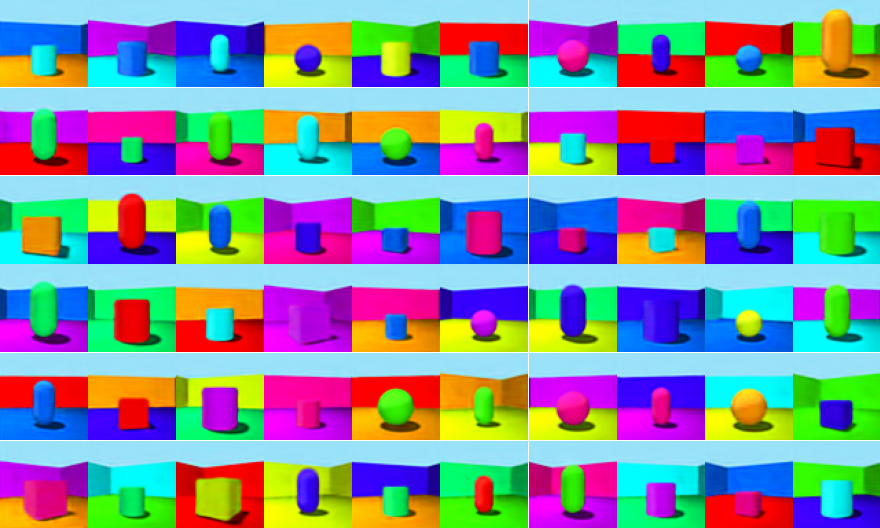

In [49]:
util.plot_imgs(R);

In [50]:
from src.responses import response_mat, conditioned_response_mat, score_from_conditioned_response_mat

In [51]:
with torch.no_grad():
    mat = response_mat(model, device=device, pbar=tqdm)

  0%|          | 0/24 [00:00<?, ?it/s]

In [66]:
batches = iter(torch.randperm(len(data)).split(128))
Ss = []

In [67]:

with torch.no_grad():
    for _ in range(8):
        s = model.encode(data[next(batches)][0].to(device))
        if isinstance(s, distrib.Distribution):
            s = s.mean
        Ss.append(s.cpu())
S = torch.cat(Ss)
S.shape

torch.Size([1024, 24])

In [85]:
with torch.no_grad():
    mat = response_mat(model, device=device, pbar=tqdm, num_samples=128)

  0%|          | 0/24 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


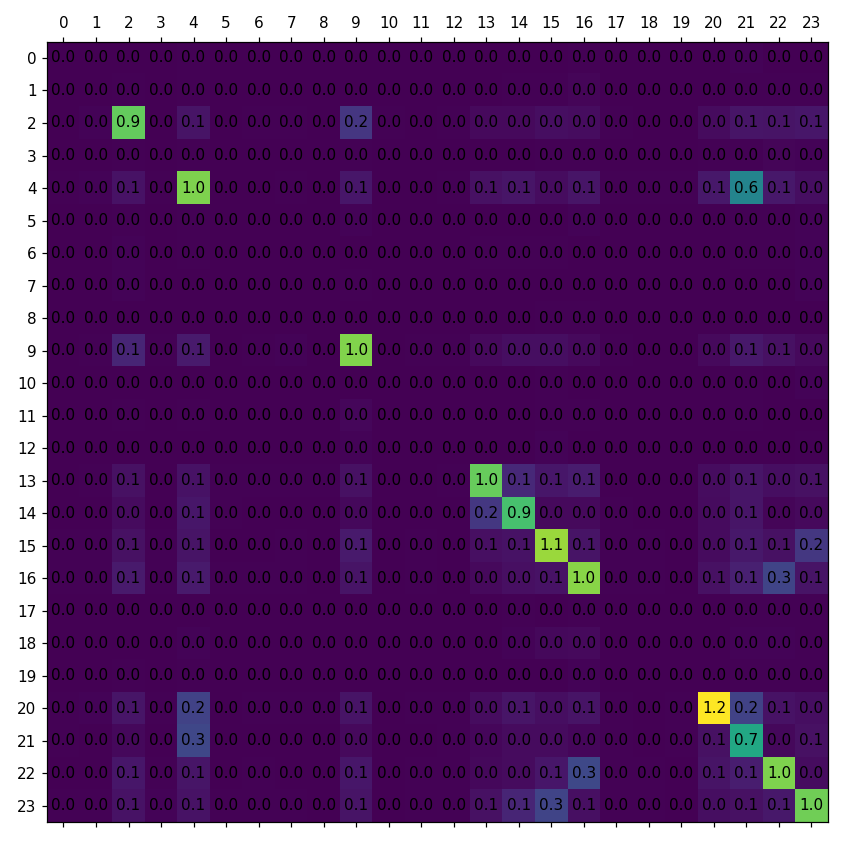

In [86]:
util.plot_mat(mat, val_fmt='.1f', figside=0.3,);
plt.tight_layout();

In [88]:
with torch.no_grad():
    cond_mat = conditioned_response_mat(model, data, device=device, num_traversals=20, pbar=tqdm)
cond_mat.shape

floor_hue:   0%|          | 0/20 [00:00<?, ?it/s]

wall_hue:   0%|          | 0/20 [00:00<?, ?it/s]

object_hue:   0%|          | 0/20 [00:00<?, ?it/s]

scale:   0%|          | 0/20 [00:00<?, ?it/s]

shape:   0%|          | 0/20 [00:00<?, ?it/s]

orientation:   0%|          | 0/20 [00:00<?, ?it/s]

torch.Size([6, 24])

<IPython.core.display.Javascript object>


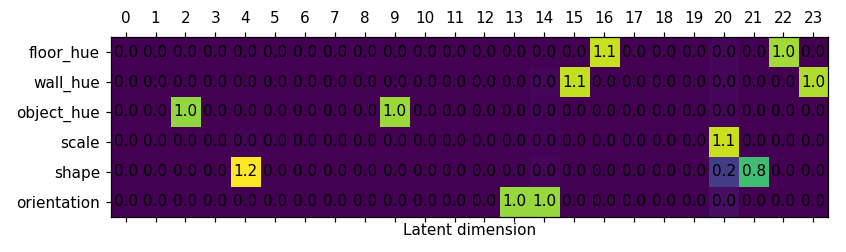

In [89]:
util.plot_mat(cond_mat, val_fmt='.1f', figside=0.3,);
plt.yticks(range(len(data.factor_order)), data.factor_order)
plt.xlabel('Latent dimension');
plt.tight_layout();

In [90]:
score = score_from_conditioned_response_mat(cond_mat)
print(f'Causal Disentanglement Score: {score:2.4f}')

Causal Disentanglement Score: 0.9629
